In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import callbacks

# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "mfcc_data_more.json"

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfccs"])
    y = np.array(data["labels"])
    genres = data["genres"]

    print("Data succesfully loaded!")

    return  X, y, genres

In [13]:
# load data
X, y, genres = load_data(DATA_PATH)

Data succesfully loaded!


In [14]:
# create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
# build network topology
model = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu'),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu'),

    # 3rd dense layer
    keras.layers.Dense(128, activation='relu'),
    
    # 4th dense layer
    keras.layers.Dense(64, activation='relu'),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 8620)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               4413952   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 7)                 455       
                                                                 
Total params: 4,586,887
Trainable params: 4,586,887
No

In [16]:
# train model
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 8, 
                                        restore_best_weights = True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=30,callbacks=[earlystopping])

Epoch 1/30
32/32 [==============================] - 2s 51ms/step - loss: 9.9117 - accuracy: 0.3548 - val_loss: 4.8179 - val_accuracy: 0.4466
Epoch 2/30
32/32 [==============================] - 2s 48ms/step - loss: 3.5954 - accuracy: 0.5560 - val_loss: 3.0365 - val_accuracy: 0.5415
Epoch 3/30
32/32 [==============================] - 2s 49ms/step - loss: 1.8667 - accuracy: 0.6799 - val_loss: 2.6500 - val_accuracy: 0.6047
Epoch 4/30
32/32 [==============================] - 2s 48ms/step - loss: 1.0598 - accuracy: 0.7770 - val_loss: 2.6970 - val_accuracy: 0.5850
Epoch 5/30
32/32 [==============================] - 1s 46ms/step - loss: 0.5926 - accuracy: 0.8494 - val_loss: 2.7057 - val_accuracy: 0.5731
Epoch 6/30
32/32 [==============================] - 1s 47ms/step - loss: 0.4382 - accuracy: 0.8731 - val_loss: 2.7036 - val_accuracy: 0.6047
Epoch 7/30
32/32 [==============================] - 2s 47ms/step - loss: 0.3092 - accuracy: 0.9118 - val_loss: 2.7083 - val_accuracy: 0.6047
Epoch 8/30
32

Evaluate on test data
4/4 [==============================] - 0s 6ms/step - loss: 2.6079 - accuracy: 0.6482
test loss, test acc: [2.607898712158203, 0.6482213735580444]


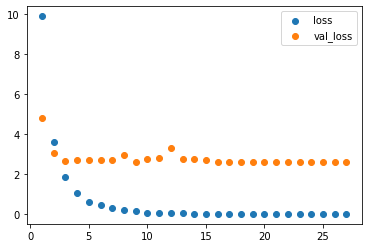

In [17]:
plt.scatter([i+1 for i in range(len(history.history['loss']))],history.history['loss'])
plt.scatter([i+1 for i in range(len(history.history['val_loss']))],history.history['val_loss'])
plt.legend(['loss','val_loss'])
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

In [18]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for tests")
predictions = model.predict(X_test)

Generate predictions for tests
8/8 [==============================] - 0s 6ms/step


In [19]:
correct = [0 for genre in genres]
pred_data = [[0 for g in genres] for genre in genres]
pred_count = [[0 for g in genres] for genre in genres]
genre_count = [0 for genre in genres]
for i in range(predictions.shape[0]):
    max_confidence = max(predictions[i])
    pred = np.argmax(predictions[i])
    actual = y_test[i]
    
    genre_count[actual] += 1
    pred_count[actual][pred] += 1
    pred_data[actual] += predictions[i]
    
    if pred == actual:
        correct[actual] += 1
#     print('Prediction:', genres[pred], '\tActual:', genres[actual], '\nConfidence:', max(predictions[i]),'\n')

pred_data = np.asarray(pred_data) / genre_count

In [20]:
curr_genre = 0
for c,g in zip(correct,genre_count):
    print(genres[curr_genre], ': ', c / g * 100,'% correct')
    curr_genre += 1

print('\nTotal: ', sum(correct) / sum(genre_count) * 100, '% correct')

blues :  37.03703703703704 % correct
classical :  97.2972972972973 % correct
disco :  32.5 % correct
jazz :  66.66666666666666 % correct
metal :  90.69767441860465 % correct
pop :  76.19047619047619 % correct
reggae :  46.51162790697674 % correct

Total:  64.82213438735178 % correct


In [21]:
# Bar graphs for genre-specific confidence levels
# counter = 0
# for dist in pred_data:
#     plt.figure(counter, figsize=(8, 6))
#     plt.bar(x=genres, height=dist, color='#0504aa', alpha=0.7, width=0.8)
#     plt.grid(axis='y', alpha=0.75)
#     plt.xlabel('Genres')
#     plt.ylabel('Confidence')
#     plt.title(genres[counter])
#     counter += 1

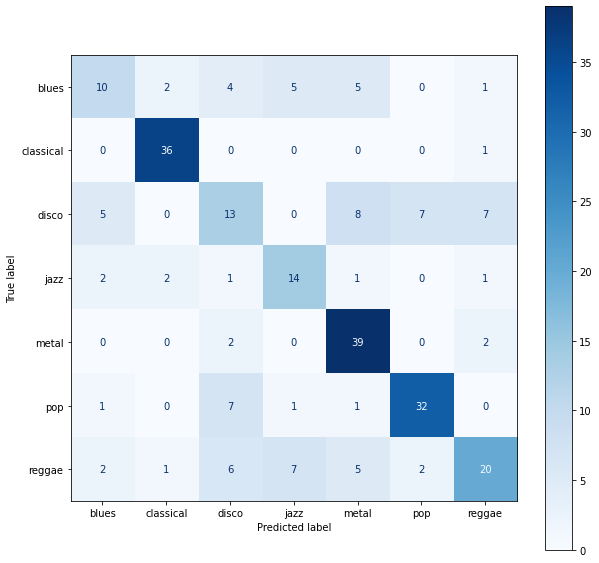

In [22]:
# Confusion matrix
confusion_matrix = np.asarray(pred_count)
# print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = genres)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax = ax, cmap='Blues')
plt.show()

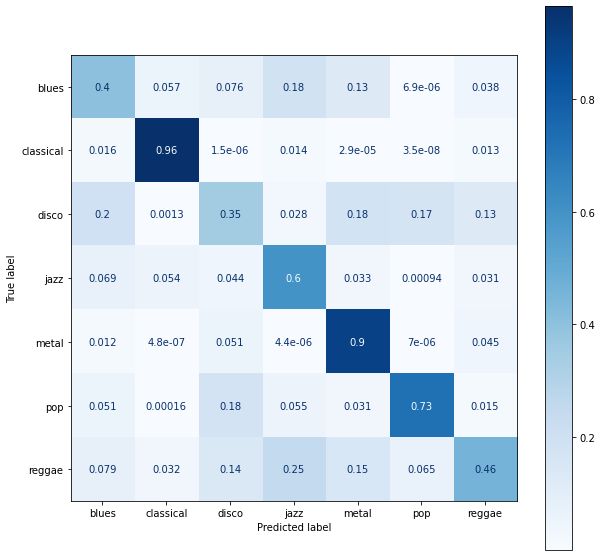

In [23]:
# Confusion matrix
confusion_matrix = np.asarray(pred_data)
# print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = genres)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax = ax, cmap='Blues')
plt.show()